Dataset extracted to /content/CaltechDataset
Test Accuracy: 75.00%
Confusion matrix:
[   5    0    0    0    0]
[   0    2    0    1    1]
[   0    0    0    0    2]
[   0    0    0    5    0]
[   1    0    0    0    3]


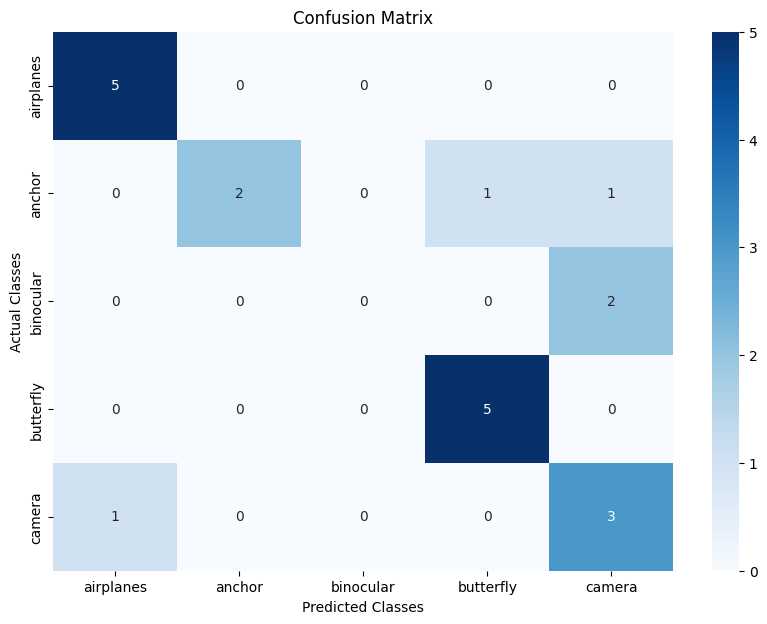

In [2]:
import os
import cv2
import numpy as np
from zipfile import ZipFile
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def unzip_dataset(zip_path, extract_folder):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print(f"Dataset extracted to {extract_folder}")

def load_and_process_image(image_path):
    # Here We are loading the image
    image = cv2.imread(image_path)
    # Here we check If the image is grayscale, we convert it to RGB
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Here we resize image to 224x224
    resized_image = cv2.resize(image, (224, 224))
    # Convert image to grayscale (required for HOG in OpenCV)
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)
    # Here we  create HOG Descriptor
    hog = cv2.HOGDescriptor()
    # Here we compute HOG features
    hog_features = hog.compute(gray_image)
    return hog_features.flatten()

def process_dataset(dataset_path, selected_classes, limit_per_class=10):
    X = []  # Feature matrix
    y = []  # Label vector
    for class_name in selected_classes:
        class_path = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_path)[:limit_per_class]
        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            try:
                features = load_and_process_image(image_path)
                X.append(features)
                y.append(class_name)
            except Exception as e:
                print(f"Error processing {image_file}: {str(e)}")
    return np.array(X), np.array(y)

# Here i  Unzipped  the dataset
zip_path = '/content/HW4.zip'
extract_folder = '/content/CaltechDataset'
unzip_dataset(zip_path, extract_folder)

# Set up the paths to the data
train_path = os.path.join(extract_folder, "HWData/train")
test_path = os.path.join(extract_folder, "HWData/test")

# List the contents of the train directory
train_contents = os.listdir(train_path)

# Process images from the first 5 classes for demonstration
selected_classes = train_contents[:5]
X_train, y_train = process_dataset(train_path, selected_classes, limit_per_class=20)
X_test, y_test = process_dataset(test_path, selected_classes, limit_per_class=5)

# Encode class labels to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Set up the SVM classifier with the One-vs-Rest strategy
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))

# Train the classifier
classifier.fit(X_train, y_train_encoded)

# Predict using the classifier
predictions = classifier.predict(X_test)

#  Here calculated accuracy
accuracy = accuracy_score(y_test_encoded, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")  # Print accuracy as a percentage

# Create confusion matrix
cm = confusion_matrix(y_test_encoded, predictions)

# Print confusion matrix in the desired format (text-based)
print("Confusion matrix:")
for row in cm:
    print("[" + " ".join(f"{x:4}" for x in row) + "]")

# Ploting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()

